In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/links.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/keywords.csv


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

In [3]:
df_credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')
df_keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')
df_links_small = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv')
df_links = pd.read_csv('/kaggle/input/the-movies-dataset/links.csv')
df_md = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
df_ratings = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')
# df_ratings=pd.read_csv('/kaggle/input/ratings.csv',header=0)

# Only ratings having value greater than 3
# df_ratings=df_ratings.query('rating>=3')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
#only consider ratings from users who have rated over n movies
n=500
df_users = df_ratings.userId.value_counts()
df_users = df_users[df_users>n].index.tolist()

In [5]:
# df_movies=df_ratings.movieId.value_counts()
df_movies=df_ratings.movieId.unique().tolist()
len(df_movies)

9066

In [6]:
len(df_users)

37

In [7]:
df_ratings = df_ratings.query('userId in @df_users')
print(df_ratings.shape)
df_ratings.head(3)

(33545, 4)


,userId,movieId,rating,timestamp
962,15,1,2.0,997938310
963,15,2,2.0,1134521380
964,15,5,4.5,1093070098


# Random Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ratings, test_size=0.2)

In [9]:
df_users = df_ratings.userId.unique()
df_movies = df_ratings.movieId.unique()

In [10]:
sparsity = 1. * df_ratings.shape[0] / (len(df_users) * len(df_movies))

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df_ratings.shape[0], len(df_users), len(df_movies), sparsity * 100))

After filtering, there are 33545 watching events from 37 users and 7477 movies (sparsity: 12.125%)


In [11]:
print(df_train.shape,df_test.shape)

(26836, 4) (6709, 4)


In [12]:
# Model Architecture
import keras 
from keras.layers import merge

# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_ratings['userId'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_ratings['movieId'].unique())}


# Create correctly mapped train- & testset
train_user_data = df_train['userId'].map(user_id_mapping)
train_movie_data = df_train['movieId'].map(movie_id_mapping)

test_user_data = df_test['userId'].map(user_id_mapping)
test_movie_data = df_test['movieId'].map(movie_id_mapping)


n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(df_ratings.userId.unique()), len(df_ratings.movieId.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)


# concat = keras.layers.merge.Concatenate(axis=1)([movie_vec_mlp, user_vec_mlp],name='Concat')
# concat = keras.layers.concatenate([movie_vec_mlp, user_vec_mlp], mode='concat',name='Concat')
concat = keras.layers.concatenate([movie_vec_mlp, user_vec_mlp],name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.Dot(1, normalize=False)([movie_vec_mf, user_vec_mf])


pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

# combine_mlp_mf = keras.layers.merge([pred_mf, pred_mlp], mode='concat',name='Concat-MF-MLP')
combine_mlp_mf = keras.layers.concatenate([pred_mf, pred_mlp],name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

Using TensorFlow backend.


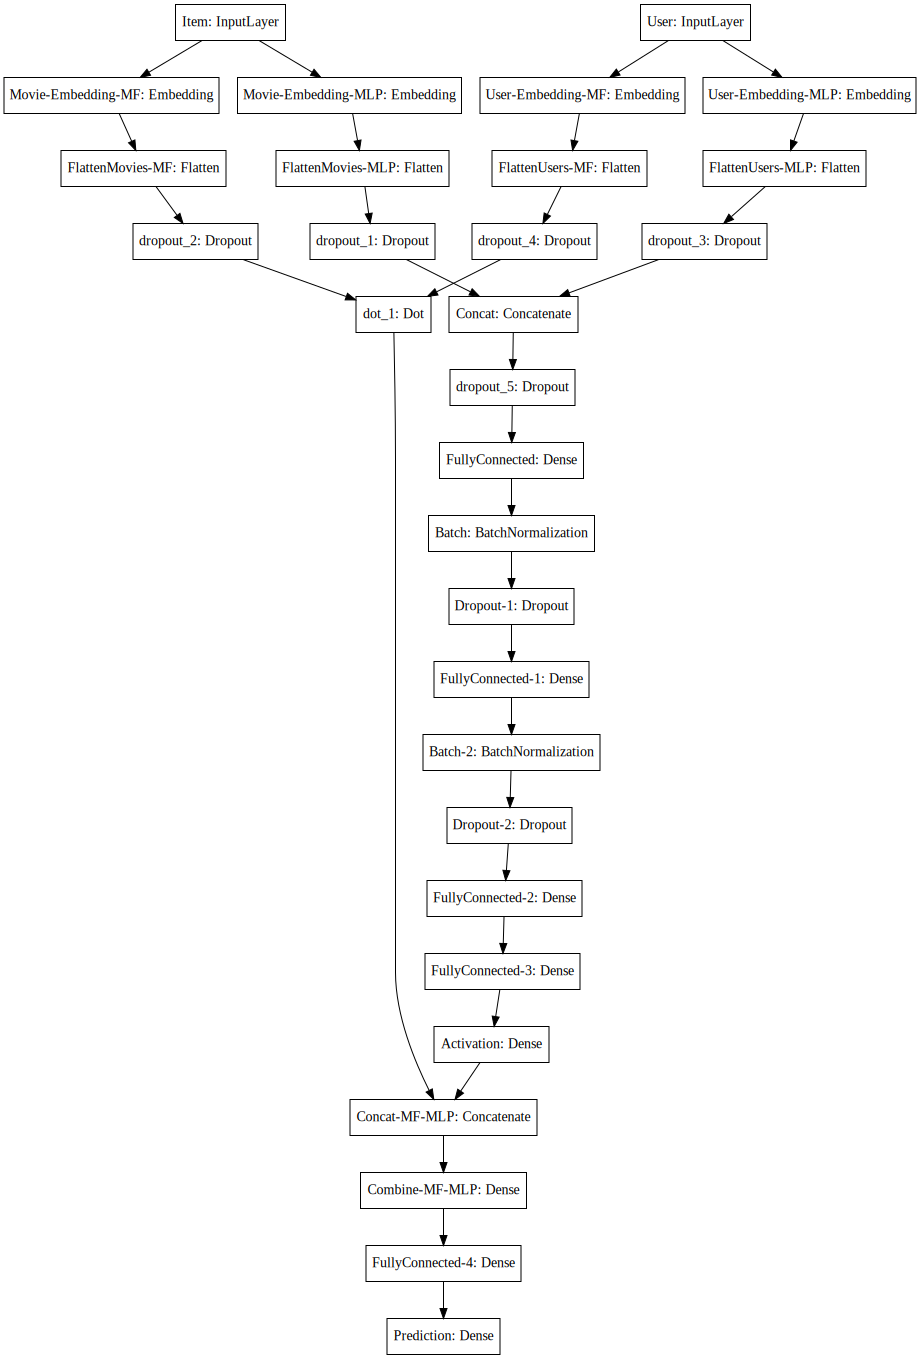

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [14]:
history = model.fit([train_user_data, train_movie_data], df_train.rating, epochs=25, verbose=0, validation_split=0.1)

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#  Compute RMSE
y_true = df_test.rating
y_pred=model.predict([test_user_data, test_movie_data])
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result with Neural Collaborative MF: {:.4f} RMSE'.format(rmse))



Testing Result with Neural Collaborative MF: 0.9567 RMSE


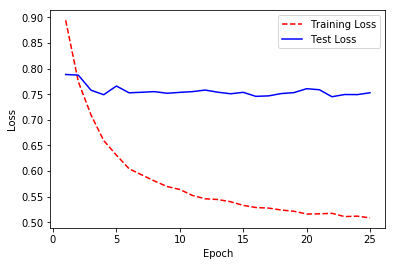

In [16]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Recommendations

In [17]:
#format test data
df_test_grp_user = df_test.copy().groupby('userId')['movieId'].agg({'Actual': (lambda x: list(set(x)))})
df_test_grp_user.head()

,Actual
userId,
15,"[2, 16, 19, 122904, 4121, 122920, 122924, 6188..."
23,"[6666, 1036, 2068, 20, 34326, 30749, 7713, 362..."
30,"[2, 1027, 1028, 4615, 14, 4627, 532, 21, 23, 2..."
48,"[114180, 1544, 77837, 62999, 102445, 2617, 569..."
56,"[69122, 2572, 527, 529, 152081, 3608, 3104, 74..."


In [18]:
recs = []
for user in df_test_grp_user.index:
#     df_test_user = df_ratings[df_ratings['userId']==user]
#     df_test_movie = df_ratings[df_ratings['movieId'].isin(df_test_user['movieId']) == False][['movieId']].drop_duplicates()
    df_test_movie = df_ratings[['movieId']].drop_duplicates()
    test_movie_data1 = df_test_movie['movieId'].map(movie_id_mapping)
#     test_movie_data1 = df_test_movie['movieId']
    test_user_data1 = np.array([user_id_mapping[user] for i in range(len(df_test_movie))])
    y_pred = model.predict([test_user_data1,test_movie_data1]) 
    df_test_movie['Predicted_Rating'] = y_pred
    df_test_movie=df_test_movie.sort_values('Predicted_Rating',ascending=False)
    recs.append(df_test_movie['movieId'].head(150).values.tolist())

df_test_grp_user['MF_Predictions'] = recs
df_test_grp_user.head()  

,Actual,MF_Predictions
userId,,
15,"[2, 16, 19, 122904, 4121, 122920, 122924, 6188...","[5960, 2535, 112460, 8650, 2730, 40412, 3216, ..."
23,"[6666, 1036, 2068, 20, 34326, 30749, 7713, 362...","[2351, 39183, 8955, 1208, 6918, 109374, 955, 8..."
30,"[2, 1027, 1028, 4615, 14, 4627, 532, 21, 23, 2...","[4967, 5960, 5047, 5847, 5244, 4705, 2858, 780..."
48,"[114180, 1544, 77837, 62999, 102445, 2617, 569...","[2351, 39183, 109374, 59684, 1361, 8132, 955, ..."
56,"[69122, 2572, 527, 529, 152081, 3608, 3104, 74...","[65037, 59684, 83318, 3677, 25769, 3550, 76173..."


In [19]:
df_test_grp_user['Actual Length']=df_test_grp_user['Actual'].apply(lambda x: len(x))
df_test_grp_user['NMF_Preds Length']=df_test_grp_user['MF_Predictions'].apply(lambda x: len(x))
df_test_grp_user.head()

,Actual,MF_Predictions,Actual Length,NMF_Preds Length
userId,,,,
15,"[2, 16, 19, 122904, 4121, 122920, 122924, 6188...","[5960, 2535, 112460, 8650, 2730, 40412, 3216, ...",370,150
23,"[6666, 1036, 2068, 20, 34326, 30749, 7713, 362...","[2351, 39183, 8955, 1208, 6918, 109374, 955, 8...",154,150
30,"[2, 1027, 1028, 4615, 14, 4627, 532, 21, 23, 2...","[4967, 5960, 5047, 5847, 5244, 4705, 2858, 780...",213,150
48,"[114180, 1544, 77837, 62999, 102445, 2617, 569...","[2351, 39183, 109374, 59684, 1361, 8132, 955, ...",107,150
56,"[69122, 2572, 527, 529, 152081, 3608, 3104, 74...","[65037, 59684, 83318, 3677, 25769, 3550, 76173...",98,150


# Evaluation

In [20]:
def mark(actual, predicted, k=10):
    """
    Computes the mean average recall at k.
    Parameters
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        mark: int
            The mean average recall at k (mar@k)
    """
    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

In [21]:
def _ark(actual, predicted, k=10):
    """
    Computes the average recall at k.
    Parameters
    ----------
    actual : list
        A list of actual items to be predicted
    predicted : list
        An ordered list of predicted items
    k : int, default = 10
        Number of predictions to consider
    Returns:
    -------
    score : int
        The average recall at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return (score / len(actual) * 100)

In [22]:
actual = df_test_grp_user.Actual.values.tolist()
mf_predictions = df_test_grp_user.MF_Predictions.values.tolist()
print('MAR@K25:',mark(actual, mf_predictions, k=25))
print('MAR@K50:',mark(actual, mf_predictions, k=50))
print('MAR@K75:',mark(actual, mf_predictions, k=75))
print('MAR@K100:',mark(actual, mf_predictions, k=100))
print('MAR@K125:',mark(actual, mf_predictions, k=125))
print('MAR@K150:',mark(actual, mf_predictions, k=150))

MAR@K25: 0.046695123803292424
MAR@K50: 0.06129077348266909
MAR@K75: 0.0885215509365155
MAR@K100: 0.10789126723845546
MAR@K125: 0.12438877140891855
MAR@K150: 0.14525758762271423


In [23]:
def recommender_precision(predicted, actual):
    """
    Computes the precision of each user's list of recommendations, and averages precision over all users.
    ----------
    actual : a list of lists
        Actual items to be predicted
        example: [['A', 'B', 'X'], ['A', 'B', 'Y']]
    predicted : a list of lists
        Ordered predictions
        example: [['X', 'Y', 'Z'], ['X', 'Y', 'Z']]
    Returns:
    -------
        precision: int
    """
    def calc_precision(predicted, actual):
        prec = [value for value in predicted if value in actual]
        prec = np.round(float(len(prec)) / float(len(predicted)), 4)
        return prec

    precision = np.mean(list(map(calc_precision,predicted,actual))) * 100
    return precision

In [24]:
print('Precision for MF recommender system is:',recommender_precision(actual,mf_predictions))

Precision for MF recommender system is: 2.744594594594595
